In [1]:
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    PATH_DRIVER = '/content/gdrive/My Drive/'
    DATA_FOLDER = 'Dataset/'
else:
    PATH_DRIVER = ''
    DATA_FOLDER = 'C:/Users/Lluis/Desktop/Machine Learning/radiology_ai/data/'

In [2]:
import os

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from fastai.basics import *
from fastai.callback.all import *
from fastai.data.block import *
from fastai.data.transforms import *
from fastai.vision import models
from fastai.vision.augment import *
from fastai.vision.core import PILImageBW
from fastai.vision.data import *
from fastai.vision.learner import create_cnn_model

In [3]:
from semisupervised.fixmatch.losses import FixMatchLoss
from semisupervised.fixmatch.callback import FixMatchCallback
from semisupervised.utils import TestColSplitter

In [4]:
PATH_PREFIX = os.path.join(PATH_DRIVER, DATA_FOLDER, '')
raw_folder = PATH_PREFIX + 'DICOMS'
organize_folder = PATH_PREFIX + 'pending_classification'
preprocess_folder = PATH_PREFIX + 'preprocess'

In [5]:
TEST_SIZE = 0.15
VALID_SIZE = 0.15

In [6]:
# Hyperparameters

LR = 0.002
MOMENTUM = 0.9

BATCH_SIZE = 8
RESIZE = 512
RANDOM_RESIZE_CROP = 256

MU = 7
LABEL_THRESHOLD = 0.95

LAMBDA_U = 1
# EMA_DECAY = 0.999

MODEL = models.resnet18

In [7]:
# Transformations

label_transform = [
    RandomResizedCropGPU(RANDOM_RESIZE_CROP),
    Flip(),
    Normalize()
]

class Multiply_255(Transform):
    def encodes(self, o): return o * 255

weak_transform = [
    RandomResizedCropGPU(RANDOM_RESIZE_CROP),
    Flip(),
    Multiply_255(),
    # Normalize()
]

strong_transform = [
    RandomResizedCropGPU(RANDOM_RESIZE_CROP),
    Flip(),
    Rotate(90),
    Brightness(),
    Contrast(),
    RandomErasing(),
    Multiply_255(),
    # Normalize()
]

In [8]:
# Callbacks
from fastai.callback.tensorboard import TensorBoardCallback

cbs = None
cbs = [
    TensorBoardCallback(),
    MixUp,
]

In [9]:
# Data
df = pd.read_excel(os.path.join(PATH_PREFIX, 'all.xlsx'), dtype={'ID':'string','Target':'string'})

unlabel_df = df[['ID','Target']][df['Target'].isnull()].reset_index(drop=True)
label_df = df[['ID','Target']][df['Target'].notnull()].reset_index(drop=True)

train_df, test_df = train_test_split(label_df, test_size=TEST_SIZE, shuffle=True, stratify=label_df['Target'])
train_df, val_df = train_test_split(train_df, test_size=VALID_SIZE/(1-TEST_SIZE), shuffle=True, stratify=train_df['Target'])

label_df.loc[train_df.index, 'Dataset'] = 'train'
label_df.loc[val_df.index, 'Dataset'] = 'valid'
label_df.loc[test_df.index, 'Dataset'] = 'test'

In [10]:
# DataLoaders
print(f'==> Preparing label dataloaders')

label_dl = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), MultiCategoryBlock),
    get_x=ColReader('ID', pref=preprocess_folder+'/', suff='.png'), 
    get_y=ColReader('Target'),
    splitter=TestColSplitter(col='Dataset'),
    item_tfms=Resize(RESIZE),
    batch_tfms=label_transform,
).dataloaders(label_df, bs=BATCH_SIZE, num_workers=0, shuffle_train=True, drop_last=True)

print(f'==> Preparing unlabel dataloaders')

ds_params = {
    'blocks': (ImageBlock(cls=PILImageBW)),
    'get_x': ColReader('ID', pref=preprocess_folder+'/', suff='.png'),
    'splitter': RandomSplitter(0),
    'item_tfms': Resize(RESIZE)
}
dls_params = {
    'source': unlabel_df,
    'bs': BATCH_SIZE * MU,
    'num_workers': 0,
    'shuffle_train': True,
    'drop_last': True
}

unlabel_dl = DataBlock(
    **ds_params
).dataloaders(**dls_params)

weak_transform_dl = DataBlock(
    **ds_params,
    batch_tfms = weak_transform
).dataloaders(**dls_params)

strong_transform_dl = DataBlock(
    **ds_params,
    batch_tfms = strong_transform
).dataloaders(**dls_params)

print(f'==> Preparing MixMatch callback')

fix_match_cb = FixMatchCallback(unlabel_dl, weak_transform_dl, strong_transform_dl)
if cbs is None:
    cbs = [fix_match_cb]
else:
    cbs.append(fix_match_cb)

==> Preparing label dataloaders
==> Preparing unlabel dataloaders
==> Preparing MixMatch callback


In [ ]:
# Scheduling
sched = {'lr': SchedCos(LR, LR*math.cos(7*math.pi/16))}
cbs.append(ParamScheduler(sched))
moms = (MOMENTUM) # 0.9 according to FixMatch paper

In [11]:
# Model
print("==> creating model")

def create_model(model_arq, n_out, pretrained=True, n_in=1, ema=False):
    model = create_cnn_model(model_arq, n_out=n_out, cut=None, pretrained=pretrained, n_in=n_in)
    model = model.cuda()

    if ema:
        for param in model.parameters():
            param.detach_()

    return model

classes = label_df['Target'].unique()
n_out = len(classes)

model = create_model(MODEL, n_out, pretrained=True, n_in=1)
# ema_model = create_model(MODEL, n_out, pretrained=True, n_in=1, ema=True)

==> creating model


In [12]:
# Loss
print("==> defining loss")

class_weight = compute_class_weight(class_weight='balanced', classes=classes, y=train_df['Target'])
class_weight = torch.as_tensor(class_weight).float()
if torch.cuda.is_available():
    class_weight = class_weight.cuda()

train_criterion = FixMatchLoss(unlabel_dl=unlabel_dl, n_out=n_out, bs=BATCH_SIZE, mu=MU, lambda_u=LAMBDA_U, label_threshold=LABEL_THRESHOLD, weight=class_weight)
criterion = train_criterion.Lx_criterion

==> defining loss


In [13]:
# Learner
print("==> defining learner")

Lx_metric = AvgMetric(func=criterion)
Lu_metric = AvgMetric(func=train_criterion.Lu_criterion)

f1_score = F1ScoreMulti(average='macro')
precision = PrecisionMulti(average='macro')
recall = RecallMulti(average='macro')
fastai_metrics = [
    # Lx_metric, Lu_metric, 
    f1_score,
    precision, recall
]

learn = Learner(label_dl, model, loss_func=train_criterion, opt_func=SGD, lr=LR, metrics=fastai_metrics, cbs=cbs)

# learn.fine_tune(1)
learn.fit(2)

==> defining learner
epoch     train_loss  valid_loss  f1_score  precision_score  recall_score  time    
0         12.510759   5.951274    0.495652  0.491379         0.500000      02:14     
1         6.804018    6.033536    0.495652  0.491379         0.500000      02:13     


,target,predicted,probabilities,loss
0,3,,"tensor([ 22.1423, -23.9294])",3052.24755859375
1,0,,"tensor([ 22.1672, -23.4957])",0.0
2,0,,"tensor([ 13.2586, -14.4586])",0.0
3,0,,"tensor([ 14.7741, -13.5035])",0.0
4,0,,"tensor([ 38.4713, -41.5665])",0.0
5,0,,"tensor([ 30.6681, -32.1091])",0.0
6,0,,"tensor([ 19.8252, -21.4608])",0.0
7,0,,"tensor([ 23.4646, -25.9201])",0.0


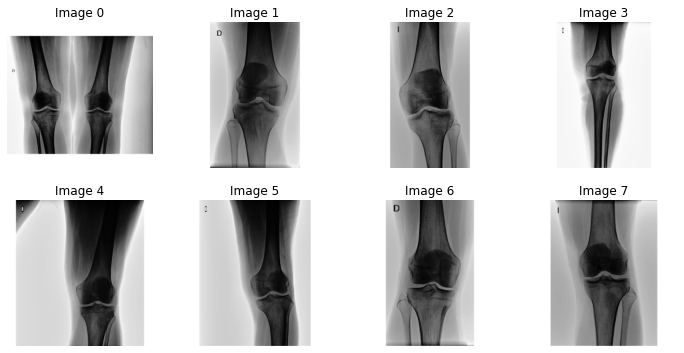

In [14]:
from fastai.interpret import ClassificationInterpretation

interp = ClassificationInterpretation.from_learner(learn, ds_idx=1)
interp.plot_top_losses(k=8)